<a href="https://colab.research.google.com/github/minjun3356/ColabDistanceAngleModel/blob/main/%EC%A4%91%EA%B0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

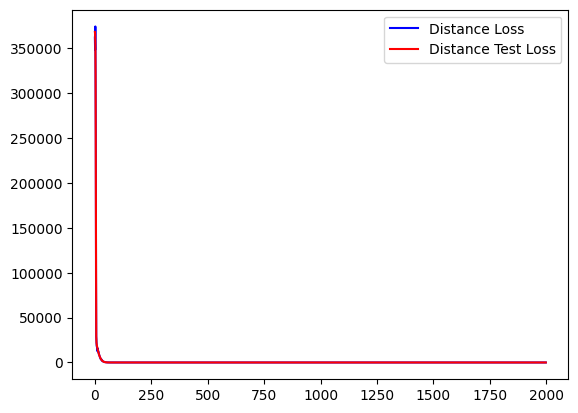

In [ ]:
import torch
from torch.utils.data import Dataset
import h5py
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from google.colab import drive

drive.mount('/content/gdrive')
device = 'cpu'
learning_rate = 0.00001            # 더 작은 학습률로 조정
Bsize = 200

path = r'/content/gdrive/My Drive/Colab Notebooks'

class H5Dataset(Dataset):
    def __init__(self, h5_path):
        super(H5Dataset, self).__init__()

        h5_file = h5py.File(h5_path, 'r')
        self.input_data_01 = h5_file['tau']       # tau로 지정
        self.output_data_r = h5_file['y_r']    # 거리 추정에 y_r, 각도 추정에 y_theta

    def __getitem__(self, index):
        inputs_01 = torch.from_numpy(self.input_data_01[index,:]).float().to(device)
        outputs_r = torch.from_numpy(self.output_data_r[index,:]).float().to(device)
        return inputs_01, outputs_r

    def __len__(self):
        return self.input_data_01.shape[0]

dataset = H5Dataset(path + '/Dataset_Mid_v03.h5')  # 다운 받은 h5파일 이름 (Mid_v03로 수정)
testset = H5Dataset(path + '/Testset_Mid_v03.h5')
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=Bsize,
    shuffle=True
)

class DistanceLayer(torch.nn.Module):
    def __init__(self):
        super(DistanceLayer, self).__init__()

        self.fc1 = torch.nn.Linear(4, 2)
        self.fc2 = torch.nn.Linear(2, 1)

        self.relu = torch.nn.ReLU()

    def forward(self, x01):
        x1 = self.relu(self.fc1(x01))
        x2 = self.fc2(x1)
        return x2

model1 = DistanceLayer()
model1.to(device)

MSE = torch.nn.MSELoss().to(device)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate)

Loss_epoch1 = np.zeros((2000,))
Loss_test_epoch1 = np.zeros((2000,))
for epoch in range(2000):
    for i, (x01, y_r) in enumerate(dataloader):
        x01_train = x01.to(device)
        y_r_train = y_r.to(device)

        optimizer1.zero_grad()
        hypothesis1 = model1(x01_train)
        cost1 = MSE(hypothesis1, y_r_train)
        cost1.backward()
        optimizer1.step()

    test_x01 = torch.from_numpy(testset.input_data_01[:,:]).float()
    test_y_r = torch.from_numpy(testset.output_data_r[:,:]).float()

    pred_y_r = model1(test_x01)

    Loss_test_epoch1[epoch] = MSE(pred_y_r, test_y_r)

    Loss_epoch1[epoch] = cost1

    plt.plot(Loss_epoch1[:epoch],'b', label='Distance Loss')
    plt.plot(Loss_test_epoch1[:epoch],'r', label='Distance Test Loss')
    plt.legend()
    plt.show()
    display.clear_output(wait=True)

    torch.save(model1, path + '/DistanceLater.h5')#빈칸에 파일이름 저장

In [ ]:
print(Loss_epoch1[-1])

9.187087016471196e-06


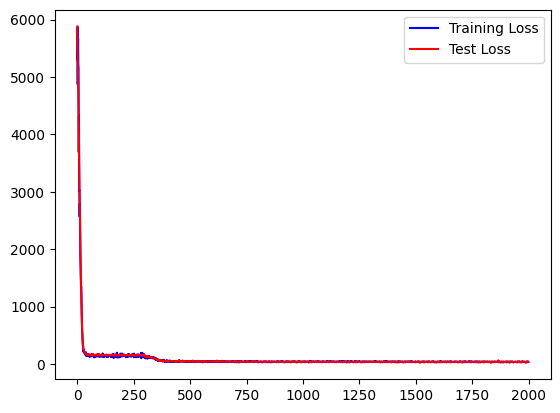

In [ ]:
import torch
from torch.utils.data import Dataset
import h5py
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from google.colab import drive

drive.mount('/content/gdrive')
device = 'cpu'
learning_rate = 0.005
Bsize = 200

path = r'/content/gdrive/My Drive/Colab Notebooks'

class H5Dataset(Dataset):
    def __init__(self, h5_path):
        super(H5Dataset, self).__init__()

        h5_file = h5py.File(h5_path, 'r')
        self.input_data_01 = h5_file['tau']
        self.output_data_theta = h5_file['y_theta']

    def __getitem__(self, index):
        inputs_01 = torch.from_numpy(self.input_data_01[index,:]).float().to(device)
        outputs_theta = torch.from_numpy(self.output_data_theta[index,:]).float().to(device)
        return inputs_01, outputs_theta

    def __len__(self):
        return self.input_data_01.shape[0]

dataset = H5Dataset(path + '/Dataset_Mid_v03.h5')
testset = H5Dataset(path + '/Testset_Mid_v03.h5')
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=Bsize,
    shuffle=True
)

class AngleLayer(torch.nn.Module):
    def __init__(self):
        super(AngleLayer, self).__init__()
        self.fc1 = torch.nn.Linear(1, 1, bias=False)
        self.fc1.weight.data.fill_(1500)

        self.fc2 = torch.nn.Linear(2, 4, bias=True)
        self.fc3 = torch.nn.Linear(4, 4, bias=True)
        self.fc4 = torch.nn.Linear(4, 4, bias=True)
        self.fc5 = torch.nn.Linear(4, 4, bias=True)
        self.fc6 = torch.nn.Linear(4, 1, bias=True)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        tau1 = torch.reshape(x[:,0], (x.size()[0],1))
        tau2 = torch.reshape(x[:,1], (x.size()[0],1))
        tau3 = torch.reshape(x[:,2], (x.size()[0],1))
        tau4 = torch.reshape(x[:,3], (x.size()[0],1))

        rho1 = self.relu(self.fc1(tau1))
        rho2 = self.relu(self.fc1(tau2))
        rho3 = self.relu(self.fc1(tau3))
        rho4 = self.relu(self.fc1(tau4))

        rho1_squared = (rho1 ** 2)
        rho2_squared = (rho2 ** 2)
        rho3_squared = (rho3 ** 2)
        rho4_squared = (rho4 ** 2)

        tau13_minus = (rho1_squared - rho3_squared)
        tau24_minus = (rho2_squared - rho4_squared)

        final = torch.cat((tau13_minus, tau24_minus), dim=1)
        y1 = self.relu(self.fc2(final))
        y2 = self.relu(self.fc3(y1))
        y3 = self.relu(self.fc4(y2))
        y4 = self.relu(self.fc5(y3))
        y5 = self.fc6(y4)

        return y5

model = AngleLayer()
model.to(device)

MSE = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam 옵티마이저로 변경

Loss_epoch = np.zeros((2000,))
Loss_test_epoch = np.zeros((2000,))
for epoch in range(2000):
    for i, (x01, y_theta) in enumerate(dataloader,0):
        x01_train = x01.to(device)
        y_theta_train = y_theta.to(device)

        optimizer.zero_grad()
        hypothesis = model(x01_train)
        cost = MSE(hypothesis, y_theta_train)
        cost.backward()
        optimizer.step()

    test_x01 = torch.from_numpy(testset.input_data_01[:,:]).float()
    test_y_theta = torch.from_numpy(testset.output_data_theta[:,:]).float()

    pred_y_theta = model(test_x01)

    Loss_test_epoch[epoch] = MSE(pred_y_theta, test_y_theta)
    Loss_epoch[epoch] = cost

    plt.plot(Loss_epoch[:epoch],'b', label='Training Loss')
    plt.plot(Loss_test_epoch[:epoch],'r', label='Test Loss')
    plt.legend()
    plt.show()
    display.clear_output(wait=True)

torch.save(model, path + '/AngleLayer.h5')


In [ ]:
print(Loss_epoch[-1])

29.743562698364258


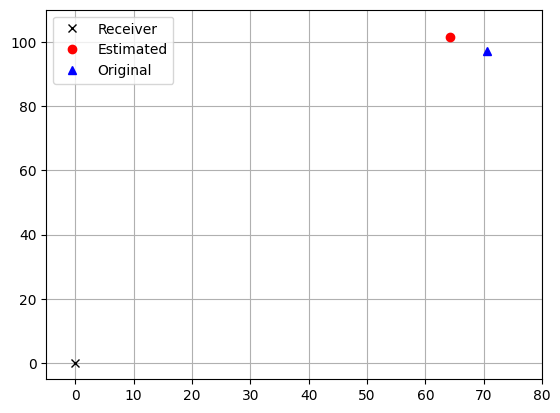

In [ ]:
import torch
from torch.utils.data import Dataset
import h5py
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from google.colab import drive

class DistanceLayer(torch.nn.Module):
    def __init__(self):
        super(DistanceLayer, self).__init__()

        self.fc1 = torch.nn.Linear(4, 2)
        self.fc2 = torch.nn.Linear(2, 1)

        self.relu = torch.nn.ReLU()

    def forward(self, x01):
        x1 = self.relu(self.fc1(x01))
        x2 = self.fc2(x1)
        return x2

class AngleLayer(torch.nn.Module):
    def __init__(self):
        super(AngleLayer, self).__init__()
        self.fc1 = torch.nn.Linear(1, 1, bias=False)
        self.fc1.weight.data.fill_(1500)

        self.fc2 = torch.nn.Linear(2, 4, bias=True)
        self.fc3 = torch.nn.Linear(4, 4, bias=True)
        self.fc4 = torch.nn.Linear(4, 4, bias=True)
        self.fc5 = torch.nn.Linear(4, 4, bias=True)
        self.fc6 = torch.nn.Linear(4, 1, bias=True)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        tau1 = torch.reshape(x[:,0], (x.size()[0],1))
        tau2 = torch.reshape(x[:,1], (x.size()[0],1))
        tau3 = torch.reshape(x[:,2], (x.size()[0],1))
        tau4 = torch.reshape(x[:,3], (x.size()[0],1))

        rho1 = self.relu(self.fc1(tau1))
        rho2 = self.relu(self.fc1(tau2))
        rho3 = self.relu(self.fc1(tau3))
        rho4 = self.relu(self.fc1(tau4))

        rho1_squared = (rho1 ** 2)
        rho2_squared = (rho2 ** 2)
        rho3_squared = (rho3 ** 2)
        rho4_squared = (rho4 ** 2)

        tau13_minus = (rho1_squared - rho3_squared)
        tau24_minus = (rho2_squared - rho4_squared)

        final = torch.cat((tau13_minus, tau24_minus), dim=1)
        y1 = self.relu(self.fc2(final))
        y2 = self.relu(self.fc3(y1))
        y3 = self.relu(self.fc4(y2))
        y4 = self.relu(self.fc5(y3))
        y5 = self.fc6(y4)

        return y5

model_dist = torch.load(path + '/DistanceLater.h5')
model_deg = torch.load(path + '/AngleLayer.h5')

A = torch.tensor([[0.0799608325062131,
                   0.0799460751371684,
                   0.0800392038553747,
                   0.0800539440568115]]).to(device)
deg_hat = model_deg(A)
dist_hat = model_dist(A)

x_hat = dist_hat*torch.cos(deg_hat/180*np.pi)
y_hat = dist_hat*torch.sin(deg_hat/180*np.pi)

plt.plot(0,0,'kx',label='Receiver')
plt.plot(x_hat.item(), y_hat.item(),'ro',label='Estimated')
plt.plot(70.5, 97.1, 'b^',label='Original')
plt.grid(True)
plt.xlim(-5, 80)
plt.ylim(-5, 110)
plt.legend()

In [ ]:
print("Estimated 좌표 (x, y):", x_hat.item(), y_hat.item())

Estimated 좌표 (x, y): 64.26013946533203 101.35063934326172


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 중간.ipynb의 사본 to 중간.ipynb의 사본
